<b> 1 Задача <b>

In [ ]:
import numpy as np

In [ ]:
class Tanh:
    def __init__(self):
        self.A = None

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.A = np.tanh(X)
        return A

    def backward(self, dL_dy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dL_dA = 1 - np.square(self.A)
        dL_dx = dL_dA*dL_dy

    def step(self, learning_rate):
        pass

<b> 2 Задача <b>

In [15]:
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import torch
import sys
from IPython.display import clear_output
from skimage.transform import rotate, resize
from skimage.util import random_noise

In [16]:
class Augmentation:
    def __init__(self, flag_rotation=True, flag_shift=True, flag_noise=True, 
                 rot_range=(-15,15), max_shift=2, var_noise=0.01):
        self.rot_range = rot_range
        self.max_shift = max_shift
        self.var_noise = var_noise
        self.flag_rotation = flag_rotation
        self.flag_shift = flag_shift
        self.flag_noise = flag_noise

        self._rotation_counter = 0
        self._shift_counter = 0
        self._noise_counter = 0

    def __call__(self, img):
        """Применяет аугментации к изображению"""
        if len(img.shape) == 1:
            # Преобразуем плоский вектор обратно в изображение 28x28
            img_2d = img.reshape(28, 28)
        else:
            img_2d = img
            
        # Применяем аугментации в соответствии с флагами
        if self.flag_rotation:
            angle = np.random.uniform(self.rot_range[0], self.rot_range[1])
            img_2d = rotate(img_2d, angle, mode='constant', cval=0)
            self._rotation_counter += 1
        
        if self.flag_shift:
            shift_x = np.random.randint(-self.max_shift, self.max_shift + 1)
            shift_y = np.random.randint(-self.max_shift, self.max_shift + 1)
            
            # Создаем новое изображение и сдвигаем
            shifted = np.zeros_like(img_2d)
            h, w = img_2d.shape
            
            # Вычисляем новые координаты
            x1 = max(0, shift_x)
            x2 = min(w, w + shift_x)
            y1 = max(0, shift_y)
            y2 = min(h, h + shift_y)
            
            # Вычисляем исходные координаты
            x1_src = max(0, -shift_x)
            x2_src = min(w, w - shift_x)
            y1_src = max(0, -shift_y)
            y2_src = min(h, h - shift_y)
            
            if x2 > x1 and y2 > y1 and x2_src > x1_src and y2_src > y1_src:
                shifted[y1:y2, x1:x2] = img_2d[y1_src:y2_src, x1_src:x2_src]
            img_2d = shifted
            self._shift_counter += 1
        
        if self.flag_noise:
            img_2d = random_noise(img_2d, mode='gaussian', var=self.var_noise)
            self._noise_counter += 1
        
        # Возвращаем обратно в плоский формат
        return img_2d.reshape(-1)

# Конфигурации аугментаций
augmentation_configs = {
    'no_aug': Augmentation(flag_rotation=False, flag_shift=False, flag_noise=False),
    'rotation_only': Augmentation(flag_rotation=True, flag_shift=False, flag_noise=False),
    'shift_only': Augmentation(flag_rotation=False, flag_shift=True, flag_noise=False),
    'noise_only': Augmentation(flag_rotation=False, flag_shift=False, flag_noise=True),
    'all_aug': Augmentation(flag_rotation=True, flag_shift=True, flag_noise=True)
}
    
        

Epoch 50/50, Loss: 0.104170, Accuracy: 0.9674


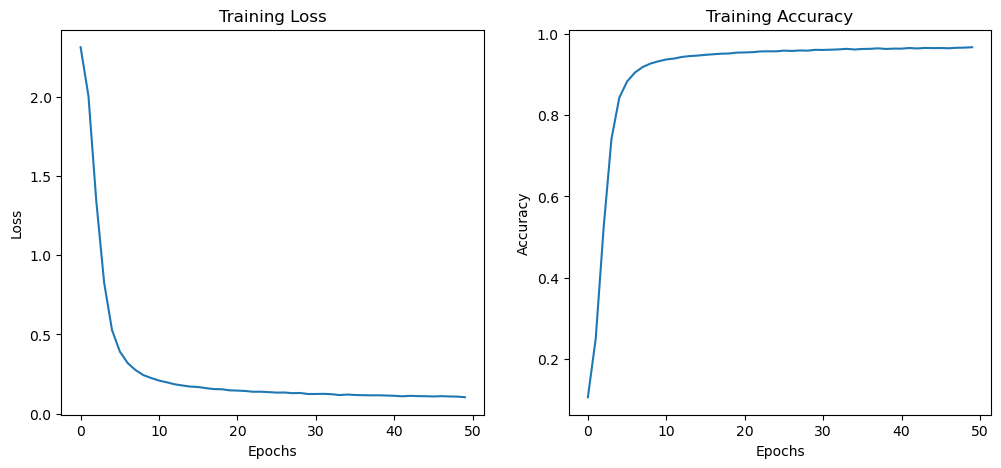

all_aug - Test Accuracy: 0.9670, Training Time: 3962.39s


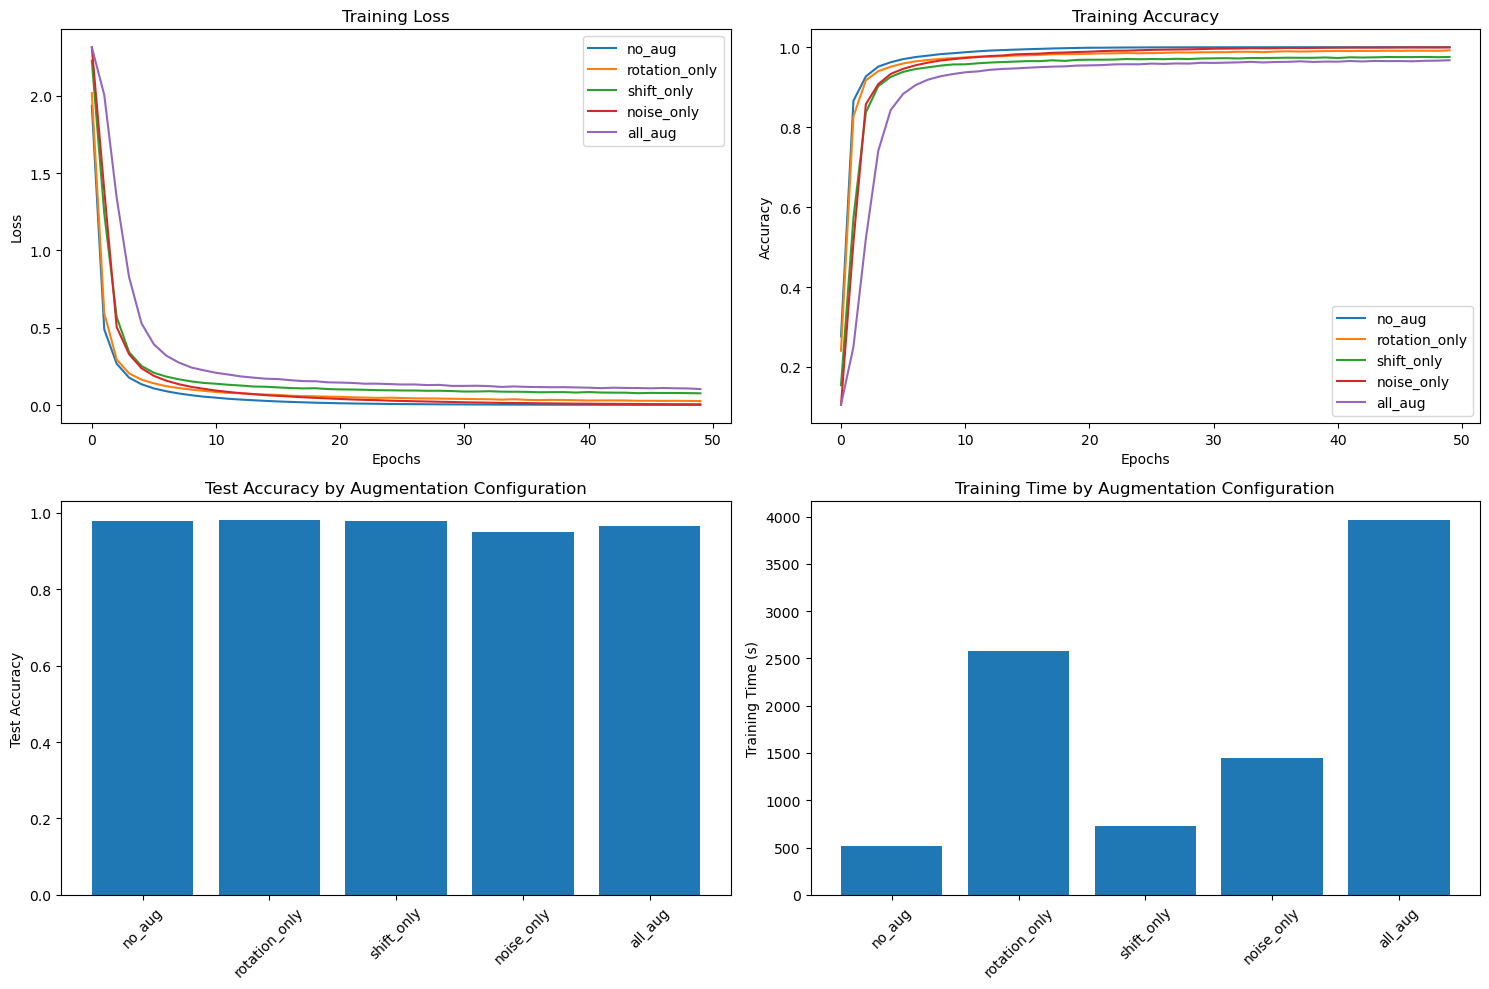

Final Results:
Configuration | Test Accuracy | Training Time (s)
--------------------------------------------------
no_aug        | 0.9780        | 512.11
rotation_only | 0.9811        | 2576.56
shift_only    | 0.9781        | 730.29
noise_only    | 0.9510        | 1450.71
all_aug       | 0.9670        | 3962.39

Baseline accuracy (no augmentation): 0.9780
rotation_only improvement: 0.0031 (0.32%)
shift_only improvement: 0.0001 (0.01%)
noise_only improvement: -0.0270 (-2.76%)
all_aug improvement: -0.0110 (-1.12%)


In [17]:
class MLPClassifier:
    def __init__(self, hidden_layer_sizes=(100,), learning_rate=0.01, n_iter=1000, 
                 momentum=0.9, batch_size=256, gradient_clip=1.0, n_classes=10):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.momentum = momentum
        self.batch_size = batch_size
        self.gradient_clip = gradient_clip
        self.n_classes = n_classes
        self.weights = []
        self.biases = []
        self.velocity_w = []
        self.velocity_b = []

    def _initialize_weights(self, n_features):
        layer_sizes = [n_features] + list(self.hidden_layer_sizes) + [self.n_classes]
        self.weights = []
        self.biases = []
        self.velocity_w = []
        self.velocity_b = []
    
        for i in range(len(layer_sizes)-1):
            self.weights.append(np.random.normal(0, 0.01, (layer_sizes[i], layer_sizes[i+1])))
            self.biases.append(np.random.normal(0, 0.01, (1, layer_sizes[i+1])))
            self.velocity_w.append(np.zeros_like(self.weights[-1]))
            self.velocity_b.append(np.zeros_like(self.biases[-1]))
        
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)

    def cross_entropy_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true])
        return np.sum(log_likelihood) / m

    def forward(self, X):
        activation = X
        self.activations = [activation]
        self.zs = []
        
        for i in range(len(self.weights) - 1):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            self.zs.append(z)
            activation = self.sigmoid(z)
            self.activations.append(activation)
        
        z_output = np.dot(activation, self.weights[-1]) + self.biases[-1]
        self.zs.append(z_output)
        output = self.softmax(z_output)
        self.activations.append(output)
        
        return output

    def backward(self, X, y):
        n_samples = X.shape[0]
        grad_w = [np.zeros_like(w) for w in self.weights]
        grad_b = [np.zeros_like(b) for b in self.biases]
        
        # Ошибка выходного слоя
        delta = self.activations[-1]
        delta[range(n_samples), y] -= 1
        delta /= n_samples
        
        # Gradient clipping
        delta = np.clip(delta, -self.gradient_clip, self.gradient_clip)
        
        # Градиенты для выходного слоя
        grad_w[-1] = np.dot(self.activations[-2].T, delta)
        grad_b[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Обратное распространение через скрытые слои
        for l in range(len(self.weights)-2, -1, -1):
            sigmoid_deriv = self.sigmoid_derivative(self.zs[l])
            delta = np.dot(delta, self.weights[l+1].T) * sigmoid_deriv
            delta = np.clip(delta, -self.gradient_clip, self.gradient_clip)
            grad_w[l] = np.dot(self.activations[l].T, delta)
            grad_b[l] = np.sum(delta, axis=0, keepdims=True)
                
        return grad_w, grad_b

    def fit(self, X, y, augmentation=None):
        if not self.weights:
            self._initialize_weights(X.shape[1])
            
        n_samples = X.shape[0]
        self.loss_history = []
        self.accuracy_history = []
        
        for epoch in range(self.n_iter):
            # Mini-batch обучение
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            epoch_accuracy = 0
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                # Применяем аугментации
                if augmentation is not None:
                    X_batch = np.array([augmentation(x) for x in X_batch])
                
                # Прямой проход
                y_pred = self.forward(X_batch)
                
                # Вычисление потерь и точности
                batch_loss = self.cross_entropy_loss(y_batch, y_pred)
                batch_accuracy = np.mean(np.argmax(y_pred, axis=1) == y_batch)
                epoch_loss += batch_loss * X_batch.shape[0]
                epoch_accuracy += batch_accuracy * X_batch.shape[0]
                
                # Обратный проход
                grad_w, grad_b = self.backward(X_batch, y_batch)
                
                # Обновление весов с momentum
                for i in range(len(self.weights)):
                    self.velocity_w[i] = self.momentum * self.velocity_w[i] - self.learning_rate * grad_w[i]
                    self.velocity_b[i] = self.momentum * self.velocity_b[i] - self.learning_rate * grad_b[i]
                    
                    self.weights[i] += self.velocity_w[i]
                    self.biases[i] += self.velocity_b[i]
            
            # Средняя потеря и точность за эпоху
            epoch_loss /= n_samples
            epoch_accuracy /= n_samples
            self.loss_history.append(epoch_loss)
            self.accuracy_history.append(epoch_accuracy)
            
            # Логирование
            if (epoch + 1) % 10 == 0:
                clear_output(True)
                print(f"Epoch {epoch+1}/{self.n_iter}, Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.4f}")
                
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(self.loss_history)
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training Loss')
                
                plt.subplot(1, 2, 2)
                plt.plot(self.accuracy_history)
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.title('Training Accuracy')
                plt.show()

    def predict(self, X):
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

# Загрузка и подготовка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

# Преобразуем данные в numpy arrays
X_train = train_dataset.data.numpy().reshape(-1, 784) / 255.0
y_train = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy().reshape(-1, 784) / 255.0
y_test = test_dataset.targets.numpy()

# Нормализуем данные
X_train = (X_train - 0.1307) / 0.3081
X_test = (X_test - 0.1307) / 0.3081

# Сравнение конфигураций аугментаций
results = {}
training_times = {}

for config_name, aug in augmentation_configs.items():
    print(f"Training with configuration: {config_name}")
    print("="*50)
    
    model = MLPClassifier(hidden_layer_sizes=(100, 100), learning_rate=0.01, n_iter=50, batch_size=32)
    
    start_time = time.time()
    model.fit(X_train, y_train, augmentation=aug)
    training_times[config_name] = time.time() - start_time
    
    test_accuracy = model.evaluate(X_test, y_test)
    results[config_name] = {
        'test_accuracy': test_accuracy,
        'loss_history': model.loss_history,
        'accuracy_history': model.accuracy_history
    }
    
    print(f"{config_name} - Test Accuracy: {test_accuracy:.4f}, Training Time: {training_times[config_name]:.2f}s")

# Визуализация результатов
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for config_name, res in results.items():
    plt.plot(res['loss_history'], label=config_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
for config_name, res in results.items():
    plt.plot(res['accuracy_history'], label=config_name)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
test_accuracies = [res['test_accuracy'] for res in results.values()]
config_names = list(results.keys())
plt.bar(config_names, test_accuracies)
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy by Augmentation Configuration')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
training_times_values = [training_times[config] for config in config_names]
plt.bar(config_names, training_times_values)
plt.ylabel('Training Time (s)')
plt.title('Training Time by Augmentation Configuration')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Анализ результатов
print("Final Results:")
print("Configuration | Test Accuracy | Training Time (s)")
print("-" * 50)
for config_name in config_names:
    print(f"{config_name:13} | {results[config_name]['test_accuracy']:.4f}        | {training_times[config_name]:.2f}")

# Анализ прироста производительности
baseline_acc = results['no_aug']['test_accuracy']
print(f"\nBaseline accuracy (no augmentation): {baseline_acc:.4f}")
for config_name, res in results.items():
    if config_name != 'no_aug':
        improvement = res['test_accuracy'] - baseline_acc
        print(f"{config_name} improvement: {improvement:.4f} ({improvement/baseline_acc*100:.2f}%)")

<H1> Вывод по влиянию аугментации <H1> 

1) Незначительный поворот улучшает качество модели на рукописных цифрах
2) Сдвиг почти не влияет на качество
3) Шум значительно ухудшает качество модели 
4) Все виды аугментаций ухудшают метрику по сравнению с моделью без них из за значительного влияния шума 